In [ ]:
# Import necessary libraries.
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import imageio
import cv2
import skimage
import skimage.io
import skimage.transform
from imageio import imread
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

In [ ]:
# Mount Google drive so dataset can be accessed (The dataset file is inside google drive.)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Load images & labels

# skimage.data has a lot of sample images to play around with
image = np.load('/content/drive/My Drive/DLCP/images.npy')                         # Images of various plant seedlings
label=pd.read_csv('/content/drive/My Drive/DLCP/Labels.csv')

In [ ]:
#Shape of data
image.shape, label.shape

((4750, 128, 128, 3), (4750, 1))

Image name:                          Label
0     Small-flowered Cranesbill
1     Small-flowered Cranesbill
2     Small-flowered Cranesbill
3     Small-flowered Cranesbill
4     Small-flowered Cranesbill
...                         ...
4745           Loose Silky-bent
4746           Loose Silky-bent
4747           Loose Silky-bent
4748           Loose Silky-bent
4749           Loose Silky-bent

[4750 rows x 1 columns]


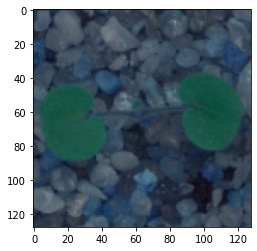

In [ ]:
#Visulalizing images
print(f'Image name:{label}')
plt.imshow(image[0])

Image name:                          Label
0     Small-flowered Cranesbill
1     Small-flowered Cranesbill
2     Small-flowered Cranesbill
3     Small-flowered Cranesbill
4     Small-flowered Cranesbill
...                         ...
4745           Loose Silky-bent
4746           Loose Silky-bent
4747           Loose Silky-bent
4748           Loose Silky-bent
4749           Loose Silky-bent

[4750 rows x 1 columns]


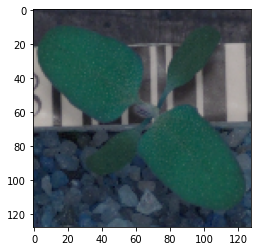

In [ ]:
print(f'Image name:{label}')
plt.imshow(image[500])

Image name:                          Label
0     Small-flowered Cranesbill
1     Small-flowered Cranesbill
2     Small-flowered Cranesbill
3     Small-flowered Cranesbill
4     Small-flowered Cranesbill
...                         ...
4745           Loose Silky-bent
4746           Loose Silky-bent
4747           Loose Silky-bent
4748           Loose Silky-bent
4749           Loose Silky-bent

[4750 rows x 1 columns]


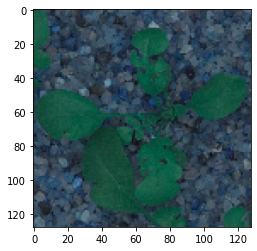

In [ ]:
print(f'Image name:{label}')
plt.imshow(image[1000])

In [ ]:
#Normalizing data
trainImg = image.astype('float32')
trainImg /= 255
# Check the nomalized data
print(f'Shape of the Train array:{trainImg.shape}')
print(f'Minimum value in the Train Array:{trainImg.min()}')
print(f'Maximum value in the Train Array:{trainImg.max()}')

Shape of the Train array:(4750, 128, 128, 3)
Minimum value in the Train Array:0.0
Maximum value in the Train Array:1.0


Now we have data that is normalized to 0-1.

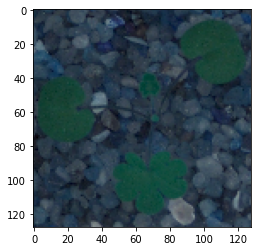

In [ ]:
#Apply Gaussian Blurring
plt.imshow(image[1], cmap='gray')

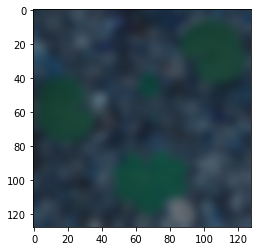

In [ ]:
plt.imshow(cv2.GaussianBlur(image[1], (15,15), 0))

In [ ]:
for idx, img in enumerate(image):
  image[idx] = cv2.GaussianBlur(img, (5, 5), 0)

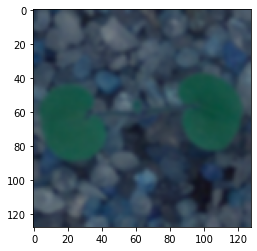

In [ ]:
plt.imshow(image[0], cmap='gray')

In [ ]:
#Convert labels to one-hot-vectors
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
label = encoder.fit_transform(label)


In [ ]:
label[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [ ]:
#Split train and test set
X_train, X_test, y_train, y_test = train_test_split(image, label, test_size=0.3, random_state=42)
X_train.shape, X_test.shape

((3325, 128, 128, 3), (1425, 128, 128, 3))

In [ ]:
#Split validation from test set
X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
X_test.shape, X_validation.shape

((712, 128, 128, 3), (713, 128, 128, 3))

In [ ]:
#Defining layers
def create_model(input_shape, num_classes):
  # Initialize CNN Classified
  model = Sequential()

  # Add convolution layer with 32 filters and 3 kernels
  model.add(Conv2D(32, (3,3), input_shape=input_shape, padding='same', activation=tf.nn.relu))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(rate=0.25))


  # Add convolution layer with 32 filters and 3 kernels
  model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation=tf.nn.relu))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(rate=0.25))

  # Flatten the 2D array to 1D array
  model.add(Flatten())

  # Create fully connected layers with 512 units
  model.add(Dense(512, activation=tf.nn.relu))
  model.add(Dropout(0.5))


  # Adding a fully connected layer with 128 neurons
  model.add(Dense(units = 128, activation = tf.nn.relu))
  model.add(Dropout(0.5))

  # The final output layer with 12 neurons to predict the categorical classifcation
  model.add(Dense(units = num_classes, activation = tf.nn.softmax))
  return model

In [ ]:
input_shape = X_train.shape[1:] # Input shape of X_train
num_classes = y_train.shape[1] # Target column size

model = create_model(input_shape, num_classes)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) # Optimizer
# optimizer = tf.keras.optimizers.SGD(lr=1 * 1e-1, momentum=0.9, nesterov=True)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=30)

Epoch 1/30
104/104 [==============================] - 1s 10ms/step - loss: 0.8086 - accuracy: 0.7293 - val_loss: 1.1048 - val_accuracy: 0.6241
Epoch 2/30
104/104 [==============================] - 1s 10ms/step - loss: 0.7832 - accuracy: 0.7248 - val_loss: 1.2312 - val_accuracy: 0.5989
Epoch 3/30
104/104 [==============================] - 1s 10ms/step - loss: 0.7505 - accuracy: 0.7504 - val_loss: 1.0657 - val_accuracy: 0.6578
Epoch 4/30
104/104 [==============================] - 1s 10ms/step - loss: 0.7108 - accuracy: 0.7594 - val_loss: 1.0147 - val_accuracy: 0.6339
Epoch 5/30
104/104 [==============================] - 1s 10ms/step - loss: 0.6809 - accuracy: 0.7639 - val_loss: 0.9016 - val_accuracy: 0.7041
Epoch 6/30
104/104 [==============================] - 1s 10ms/step - loss: 0.5789 - accuracy: 0.8039 - val_loss: 0.8679 - val_accuracy: 0.7167
Epoch 7/30
104/104 [==============================] - 1s 10ms/step - loss: 0.5261 - accuracy: 0.8135 - val_loss: 0.8522 - val_accuracy: 0.7237

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print('Test loss: {:.2f} \n Test accuracy: {:.2f}'.format(loss, accuracy))

loss, accuracy = model.evaluate(X_train, y_train)
print('Train loss: {:.2f} \n Train accuracy: {:.2f}'.format(loss, accuracy))

23/23 [==============================] - 0s 4ms/step - loss: 1.0128 - accuracy: 0.7177
Test loss: 1.01 
 Test accuracy: 0.72
104/104 [==============================] - 0s 4ms/step - loss: 0.0281 - accuracy: 0.9949
Train loss: 0.03 
 Train accuracy: 0.99


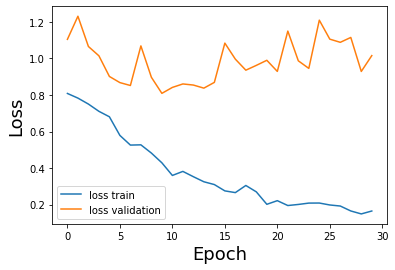

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch', fontsize=18)
plt.ylabel(r'Loss', fontsize=18)
plt.legend(('loss train','loss validation'), loc=0)

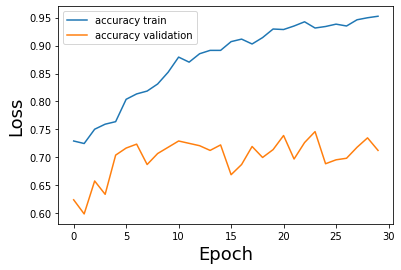

In [ ]:
# Print accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch', fontsize=18)
plt.ylabel(r'Loss', fontsize=18)
plt.legend(('accuracy train','accuracy validation'), loc=0)

In [ ]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5) 

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

=== Confusion Matrix ===
[[21  0  0  0  4  0 16  0  0  0  0  0]
 [ 1 45  7  0  0  1  0  0  0  0  1  0]
 [ 5  1 42  1  0  0  0  0  0  0  0  0]
 [ 2  0  0 82  0  0  0  1  0  0  3  0]
 [10  0  1  2 14  2  3  0  1  0  0  0]
 [ 8  3  2  1  1 55  2  0  0  0  2  0]
 [25  0  2  0  3  4 66  0  0  0  0  1]
 [ 3  0  0  1  0  1  0 25  0  0  0  0]
 [12  1  1  4  0  0  0  1 52  0  0  3]
 [14  1  0 12  0  3  0  2  8  6  2  0]
 [ 5  1  2  1  0  1  0  2  0  0 58  2]
 [ 6  1  2  2  0  4  0  1  0  0  0 31]]


Predicted label: Black-grass


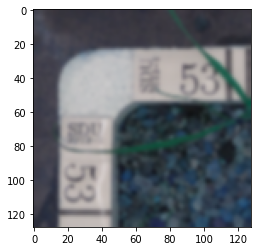

In [ ]:
 #Find prediction: x_test[2], x_test[3], x_test[33], x_test[36], x_test[59]
 y_pred = encoder.inverse_transform(y_pred)

index = 2
plt.imshow(X_test[index], cmap='gray')
print("Predicted label:", y_pred[index])

Predicted label: Common Chickweed


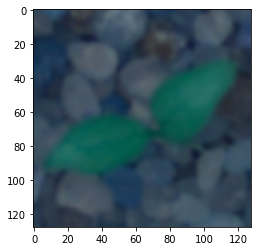

In [ ]:
index = 3
plt.imshow(X_test[index], cmap='gray')
print("Predicted label:", y_pred[index])

Predicted label: Black-grass


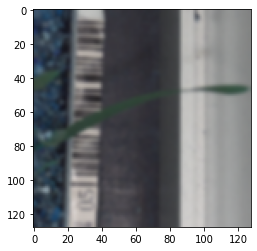

In [ ]:
index = 33
plt.imshow(X_test[index], cmap='gray')
print("Predicted label:", y_pred[index])

Predicted label: Black-grass


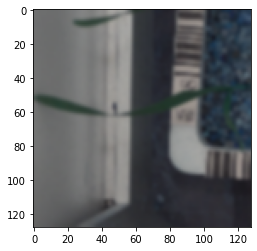

In [ ]:
index = 36
plt.imshow(X_test[index], cmap='gray')
print("Predicted label:", y_pred[index])

Predicted label: Small-flowered Cranesbill


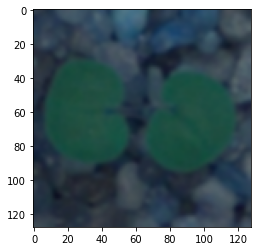

In [ ]:
index = 59
plt.imshow(X_test[index], cmap='gray')
print("Predicted label:", y_pred[index])